<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 1433, '日付': '2021-01-13T08:00:00.000Z'},
 {'小計': 1502, '日付': '2021-01-14T08:00:00.000Z'},
 {'小計': 2001, '日付': '2021-01-15T08:00:00.000Z'},
 {'小計': 1809, '日付': '2021-01-16T08:00:00.000Z'},
 {'小計': 1592, '日付': '2021-01-17T08:00:00.000Z'},
 {'小計': 1204, '日付': '2021-01-18T08:00:00.000Z'},
 {'小計': 1240, '日付': '2021-01-19T08:00:00.000Z'},
 {'小計': 1274, '日付': '2021-01-20T08:00:00.000Z'},
 {'小計': 1471, '日付': '2021-01-21T08:00:00.000Z'},
 {'小計': 1175, '日付': '2021-01-22T08:00:00.000Z'},
 {'小計': 1070, '日付': '2021-01-23T08:00:00.000Z'},
 {'小計': 986, '日付': '2021-01-24T08:00:00.000Z'},
 {'小計': 618, '日付': '2021-01-25T08:00:00.000Z'},
 {'小計': 1026, '日付': '2021-01-26T08:00:00.000Z'},
 {'小計': 973, '日付': '2021-01-27T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-01-23 17:00:00+09:00,635,0,1070,2021-01-23 17:00:00+09:00
2021-01-24 17:00:00+09:00,503,0,986,2021-01-24 17:00:00+09:00
2021-01-25 17:00:00+09:00,606,0,618,2021-01-25 17:00:00+09:00
2021-01-26 17:00:00+09:00,511,0,1026,2021-01-26 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-01-23 17:00:00+09:00,635,0,1070,2021-01-23 17:00:00+09:00,672.000000,4704.0,0.0,0.0,1289.428571,9026.0
2021-01-24 17:00:00+09:00,503,0,986,2021-01-24 17:00:00+09:00,635.428571,4448.0,0.0,0.0,1202.857143,8420.0
2021-01-25 17:00:00+09:00,606,0,618,2021-01-25 17:00:00+09:00,591.000000,4137.0,0.0,0.0,1119.142857,7834.0
2021-01-26 17:00:00+09:00,511,0,1026,2021-01-26 17:00:00+09:00,573.571429,4015.0,0.0,0.0,1088.571429,7620.0
2021-01-27 17:00:00+09:00,0,0,973,2021-01-27 17:00:00+09:00,488.714286,3421.0,0.0,0.0,1045.571429,7319.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-01-13 17:00:00+09:00,931,0,1433,2021-01-13 17:00:00+09:00,1333.142857,9332.0,0.0,0.0,1746.142857,12223.0,'21w02,Wed
2021-01-14 17:00:00+09:00,913,0,1502,2021-01-14 17:00:00+09:00,1250.285714,8752.0,0.0,0.0,1611.142857,11278.0,'21w02,Thu
2021-01-15 17:00:00+09:00,931,0,2001,2021-01-15 17:00:00+09:00,1190.428571,8333.0,0.0,0.0,1555.285714,10887.0,'21w02,Fri
2021-01-16 17:00:00+09:00,1111,0,1809,2021-01-16 17:00:00+09:00,1109.142857,7764.0,0.0,0.0,1489.714286,10428.0,'21w02,Sat
2021-01-17 17:00:00+09:00,759,0,1592,2021-01-17 17:00:00+09:00,1021.285714,7149.0,0.0,0.0,1503.714286,10526.0,'21w02,Sun
2021-01-18 17:00:00+09:00,917,0,1204,2021-01-18 17:00:00+09:00,969.714286,6788.0,0.0,0.0,1501.571429,10511.0,'21w03,Mon
2021-01-19 17:00:00+09:00,633,0,1240,2021-01-19 17:00:00+09:00,885.000000,6195.0,0.0,0.0,1540.142857,10781.0,'21w03,Tue
2021-01-20 17:00:00+09:00,594,0,1274,2021-01-20 17:00:00+09:00,836.857143,5858.0,0.0,0.0,1517.428571,10622.0,'21w03,Wed
2021-01-21 17:00:00+09:00,545,0,1471,2021-01-21 17:00:00+09:00,784.285714,5490.0,0.0,0.0,1513.000000,10591.0,'21w03,Thu
2021-01-22 17:00:00+09:00,621,0,1175,2021-01-22 17:00:00+09:00,740.000000,5180.0,0.0,0.0,1395.000000,9765.0,'21w03,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-01-10 17:00:00+09:00,1764.857143,12354
2021-01-17 17:00:00+09:00,1503.714286,10526
2021-01-24 17:00:00+09:00,1202.857143,8420
2021-01-27 17:00:00+09:00,872.333333,2617
2021-01-03 17:00:00+09:00,804.333333,2413


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-01-13 17:00:00+09:00,931,0,1433,2021-01-13 17:00:00+09:00,1333.142857,9332.0,0.0,0.0,1746.142857,12223.0,'21w02,Wed,NaN,NaN
2021-01-14 17:00:00+09:00,913,0,1502,2021-01-14 17:00:00+09:00,1250.285714,8752.0,0.0,0.0,1611.142857,11278.0,'21w02,Thu,NaN,NaN
2021-01-15 17:00:00+09:00,931,0,2001,2021-01-15 17:00:00+09:00,1190.428571,8333.0,0.0,0.0,1555.285714,10887.0,'21w02,Fri,NaN,NaN
2021-01-16 17:00:00+09:00,1111,0,1809,2021-01-16 17:00:00+09:00,1109.142857,7764.0,0.0,0.0,1489.714286,10428.0,'21w02,Sat,NaN,NaN
2021-01-17 17:00:00+09:00,759,0,1592,2021-01-17 17:00:00+09:00,1021.285714,7149.0,0.0,0.0,1503.714286,10526.0,'21w02,Sun,1503.714286,10526.0
2021-01-18 17:00:00+09:00,917,0,1204,2021-01-18 17:00:00+09:00,969.714286,6788.0,0.0,0.0,1501.571429,10511.0,'21w03,Mon,NaN,NaN
2021-01-19 17:00:00+09:00,633,0,1240,2021-01-19 17:00:00+09:00,885.000000,6195.0,0.0,0.0,1540.142857,10781.0,'21w03,Tue,NaN,NaN
2021-01-20 17:00:00+09:00,594,0,1274,2021-01-20 17:00:00+09:00,836.857143,5858.0,0.0,0.0,1517.428571,10622.0,'21w03,Wed,NaN,NaN
2021-01-21 17:00:00+09:00,545,0,1471,2021-01-21 17:00:00+09:00,784.285714,5490.0,0.0,0.0,1513.000000,10591.0,'21w03,Thu,NaN,NaN
2021-01-22 17:00:00+09:00,621,0,1175,2021-01-22 17:00:00+09:00,740.000000,5180.0,0.0,0.0,1395.000000,9765.0,'21w03,Fri,NaN,NaN


### グラフ出力

In [12]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [13]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

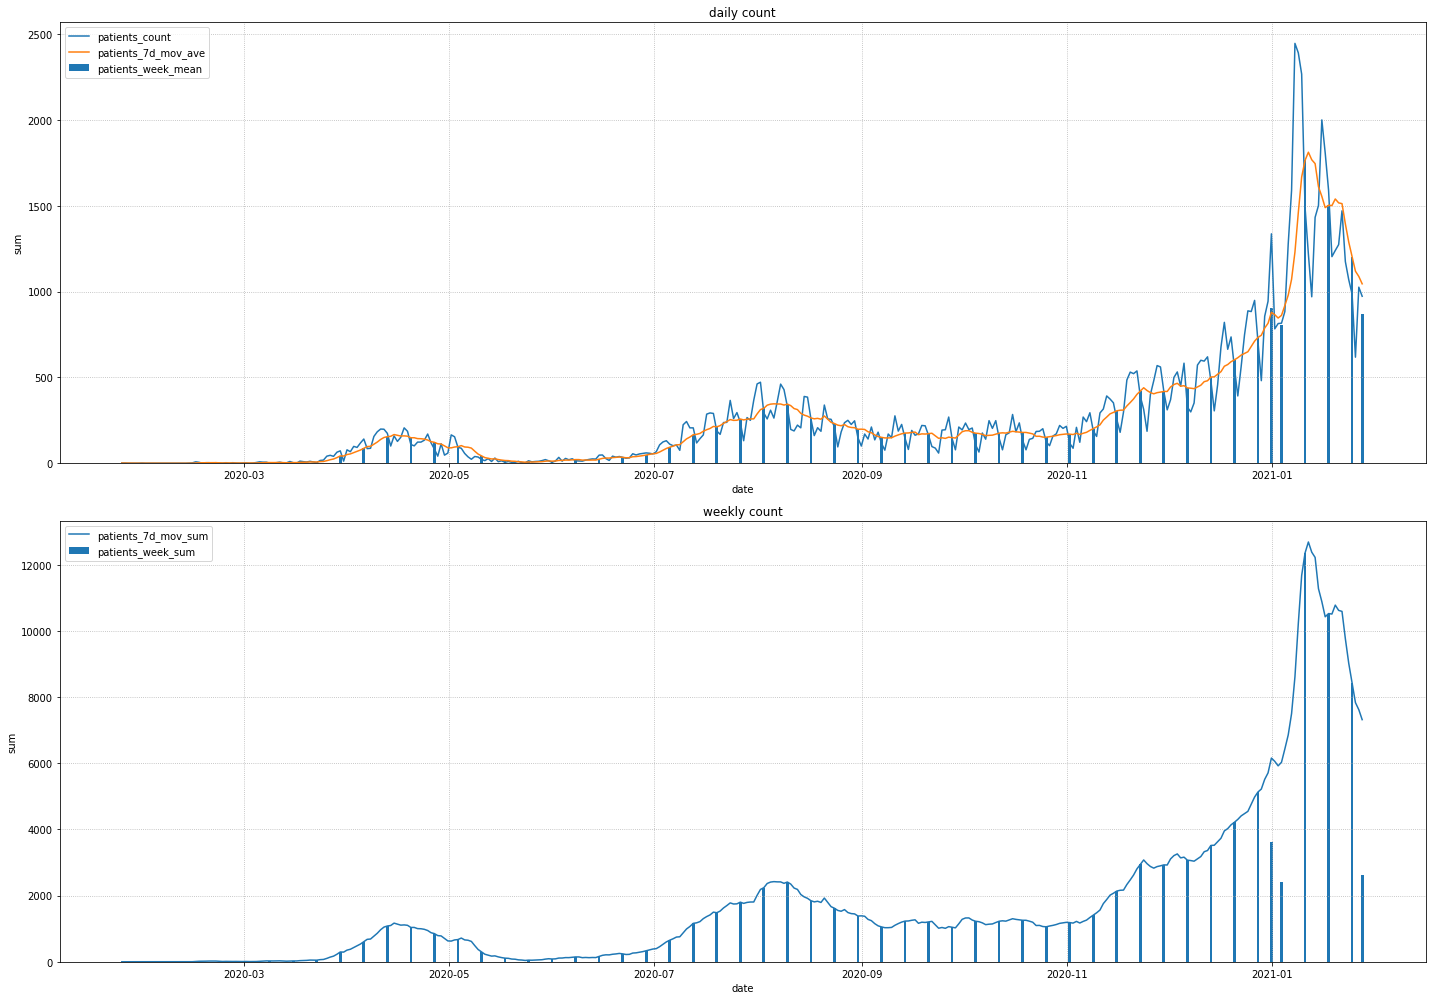

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [15]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [16]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [17]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [18]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [19]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
355,1.610525e+09,2021,1,13,0,0,0,0,0,0,1,355,0,281,931,1333.142857,9332.0,0,0.0,0.0,1433,1746.142857,12223.0
356,1.610611e+09,2021,1,14,0,0,0,0,1,0,0,356,0,282,913,1250.285714,8752.0,0,0.0,0.0,1502,1611.142857,11278.0
357,1.610698e+09,2021,1,15,1,0,0,0,0,0,0,357,0,283,931,1190.428571,8333.0,0,0.0,0.0,2001,1555.285714,10887.0
358,1.610784e+09,2021,1,16,0,0,1,0,0,0,0,358,0,284,1111,1109.142857,7764.0,0,0.0,0.0,1809,1489.714286,10428.0
359,1.610870e+09,2021,1,17,0,0,0,1,0,0,0,359,0,285,759,1021.285714,7149.0,0,0.0,0.0,1592,1503.714286,10526.0
360,1.610957e+09,2021,1,18,0,1,0,0,0,0,0,360,0,286,917,969.714286,6788.0,0,0.0,0.0,1204,1501.571429,10511.0
361,1.611043e+09,2021,1,19,0,0,0,0,0,1,0,361,0,287,633,885.000000,6195.0,0,0.0,0.0,1240,1540.142857,10781.0
362,1.611130e+09,2021,1,20,0,0,0,0,0,0,1,362,0,288,594,836.857143,5858.0,0,0.0,0.0,1274,1517.428571,10622.0
363,1.611216e+09,2021,1,21,0,0,0,0,1,0,0,363,0,289,545,784.285714,5490.0,0,0.0,0.0,1471,1513.000000,10591.0
364,1.611302e+09,2021,1,22,1,0,0,0,0,0,0,364,0,290,621,740.000000,5180.0,0,0.0,0.0,1175,1395.000000,9765.0


In [20]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            370 non-null    float64
 1   year                 370 non-null    int64  
 2   month                370 non-null    int64  
 3   day                  370 non-null    int64  
 4   Fri                  370 non-null    uint8  
 5   Mon                  370 non-null    uint8  
 6   Sat                  370 non-null    uint8  
 7   Sun                  370 non-null    uint8  
 8   Thu                  370 non-null    uint8  
 9   Tue                  370 non-null    uint8  
 10  Wed                  370 non-null    uint8  
 11  passed               370 non-null    int64  
 12  emergency            370 non-null    int64  
 13  em_passed            370 non-null    int64  
 14  contacts_count       370 non-null    int64  
 15  contacts_7d_mov_ave  370 non-null    flo

In [21]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.700000e+02,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.00000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,1.595794e+09,2020.072973,6.454054,15.862162,0.143243,0.143243,0.143243,0.143243,0.140541,0.143243,0.143243,184.50000,0.132432,118.000000,763.724324,760.490669,5323.424324,995.997297,995.997297,6971.981081,260.829730,253.224826,1772.529730
std,9.240829e+06,0.260444,3.484273,8.834211,0.350795,0.350795,0.350795,0.350795,0.348018,0.350795,0.350795,106.95404,0.339419,96.681244,462.081950,447.967574,3135.790568,875.038141,751.671783,5261.702478,382.456566,358.256386,2507.825854
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.587823e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.25000,0.000000,18.250000,457.250000,465.071429,3255.500000,0.000000,0.000000,0.000000,24.250000,21.714286,152.000000
50%,1.595794e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184.50000,0.000000,110.500000,608.500000,620.214286,4341.500000,1011.000000,1055.928571,7391.500000,147.000000,158.785714,1111.500000
75%,1.603764e+09,2020.000000,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,276.75000,0.000000,202.750000,947.000000,968.285714,6778.000000,1588.000000,1561.178571,10928.250000,289.000000,272.714286,1909.000000
max,1.611734e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,369.00000,1.000000,295.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2447.000000,1812.714286,12689.000000


In [22]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.450494,0.600267,0.017437,-0.009571,0.001914,-0.005742,-0.001914,-3.924024e-18,0.005742,0.009571,1.000000e+00,-0.316411,0.989769,-0.036517,-0.002370,-0.002365,-0.270030,-0.277081,-0.277081,0.685833,0.715331,0.715352
year,4.504944e-01,1.000000,-0.439774,-0.059221,0.003928,0.003928,0.003928,0.003928,-2.375763e-02,0.003928,0.003928,4.504944e-01,-0.109618,0.476567,0.110734,0.172529,0.172529,-0.319782,-0.372265,-0.372265,0.796820,0.857692,0.857686
month,6.002670e-01,-0.439774,1.000000,-0.012400,-0.013447,-0.002361,-0.009013,-0.004578,2.098400e-02,0.002073,0.006508,6.002670e-01,-0.218265,0.565901,-0.131747,-0.153125,-0.153119,0.017096,0.059211,0.059211,-0.024307,-0.050919,-0.050890
day,1.743719e-02,-0.059221,-0.012400,1.000000,0.003765,0.009012,-0.004105,-0.010227,4.555026e-03,0.002016,-0.004980,1.743719e-02,-0.007453,0.020967,-0.032353,-0.027822,-0.027826,-0.003754,-0.026443,-0.026443,-0.013254,0.006185,0.006166
Fri,-9.570592e-03,0.003928,-0.013447,0.003765,1.000000,-0.167192,-0.167192,-0.167192,-1.653470e-01,-0.167192,-0.167192,-9.570592e-03,-0.000431,-0.008070,-0.020203,-0.004481,-0.004480,0.046917,-0.001462,-0.001462,0.047550,-0.006489,-0.006500
Mon,1.914118e-03,0.003928,-0.002361,0.009012,-0.167192,1.000000,-0.167192,-0.167192,-1.653470e-01,-0.167192,-0.167192,1.914118e-03,-0.000431,0.001998,0.043663,-0.000185,-0.000184,0.189216,-0.001462,-0.001462,-0.095967,0.001735,0.001737
Sat,-5.742355e-03,0.003928,-0.009013,-0.004105,-0.167192,-0.167192,1.000000,-0.167192,-1.653470e-01,-0.167192,-0.167192,-5.742355e-03,-0.000431,-0.004714,0.052005,-0.002917,-0.002916,-0.221121,-0.001462,-0.001462,0.051792,-0.003196,-0.003204
Sun,-1.914118e-03,0.003928,-0.004578,-0.010227,-0.167192,-0.167192,-0.167192,1.000000,-1.653470e-01,-0.167192,-0.167192,-1.914118e-03,-0.000431,-0.001358,-0.015856,-0.001678,-0.001676,-0.203825,-0.001462,-0.001462,-0.031268,-0.000166,-0.000167
Thu,-3.924024e-18,-0.023758,0.020984,0.004555,-0.165347,-0.165347,-0.165347,-0.165347,1.000000e+00,-0.165347,-0.165347,-4.655946e-18,0.002604,-0.002014,-0.006011,0.007160,0.007162,0.063612,0.008844,0.008844,0.064011,-0.004704,-0.004697
Tue,5.742355e-03,0.003928,0.002073,0.002016,-0.167192,-0.167192,-0.167192,-0.167192,-1.653470e-01,1.000000,-0.167192,5.742355e-03,-0.000431,0.005354,-0.027258,0.001074,0.001075,0.074736,-0.001462,-0.001462,-0.035672,0.004893,0.004898


---

In [23]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [24]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,1.611389e+09,0,0,1,0,0,0,0,365,0,291,635,0,1070,1289.428571,9026.0
366,1.611475e+09,0,0,0,1,0,0,0,366,0,292,503,0,986,1202.857143,8420.0
367,1.611562e+09,0,1,0,0,0,0,0,367,0,293,606,0,618,1119.142857,7834.0
368,1.611648e+09,0,0,0,0,0,1,0,368,0,294,511,0,1026,1088.571429,7620.0


In [25]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
365,1.611389e+09,365,0,1070,1289.428571,9026.0
366,1.611475e+09,366,0,986,1202.857143,8420.0
367,1.611562e+09,367,0,618,1119.142857,7834.0
368,1.611648e+09,368,0,1026,1088.571429,7620.0


In [26]:
import seaborn as sns

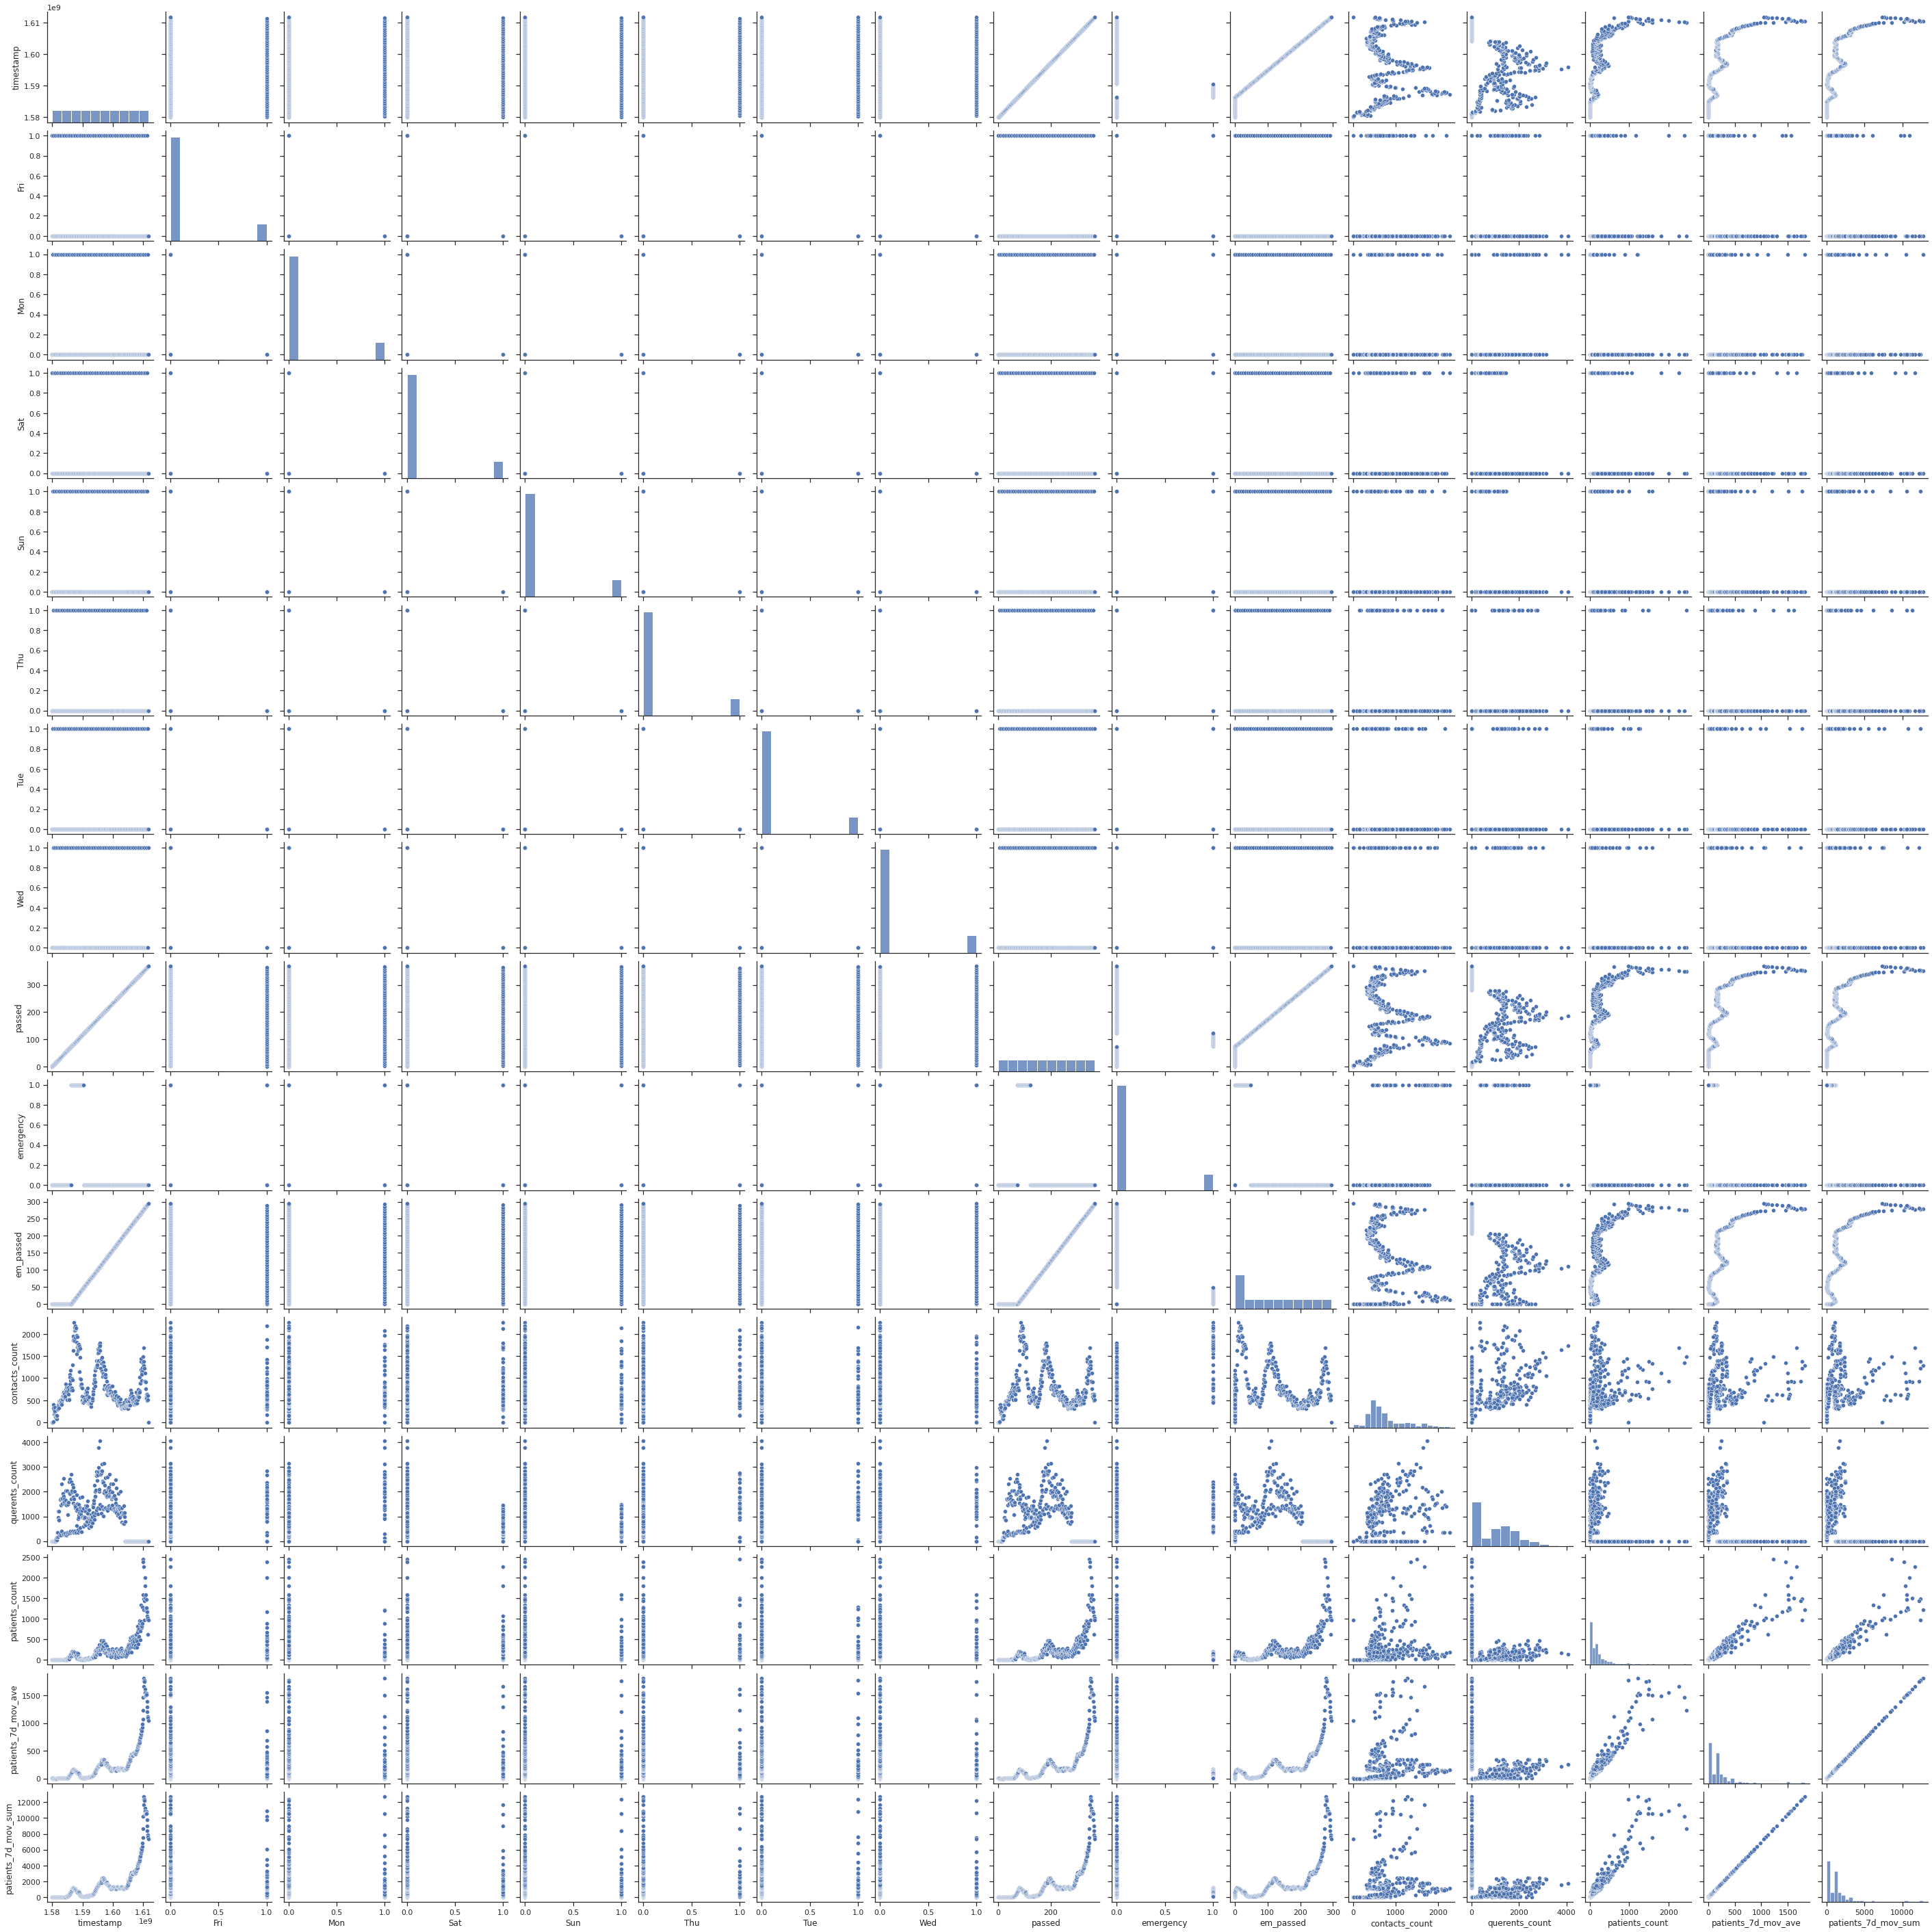

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

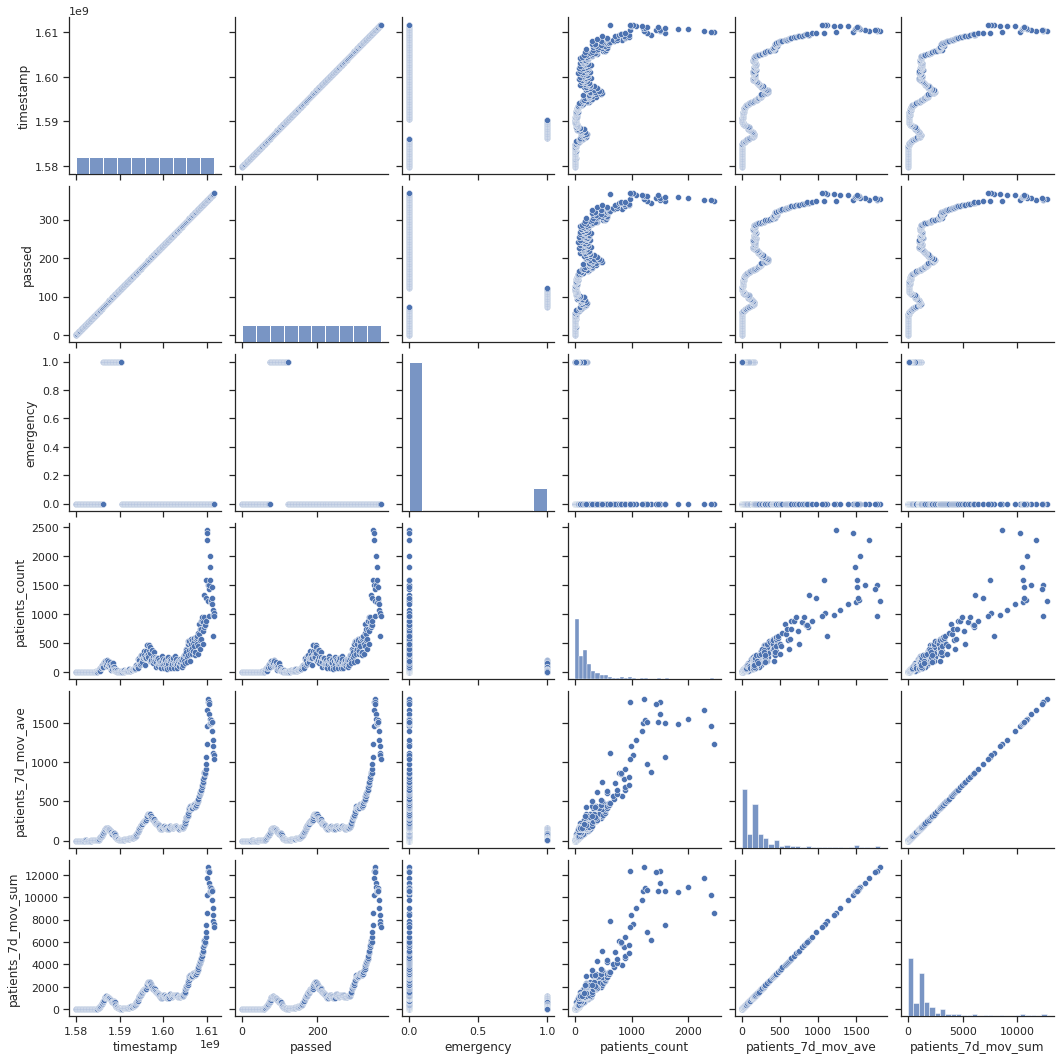

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.6.9
